In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from datetime import datetime 
import matplotlib.pyplot as plt 
import pandas as pd 

## Data from raw stream 
Process data and divide then into dictionaries containing lists.

In [2]:
data = { 'lr': [],'lc1': [],'lc2': [],'lc3': [],'mf': [],'mq': [],'mt': [],'mr': [],'mp': [],'p': [], 'wt': [],'wf': [],'wp': [],'pr': [],'pi': [],'pc': []}
times = {'lr': [],'lc1': [],'lc2': [],'lc3': [],'mf': [],'mq': [],'mt': [],'mr': [],'mp': [],'p': [], 'wt': [],'wf': [],'wp': [],'pr': [],'pi': [],'pc': []}
keys = list(data.keys())

# ====================== Break down raw datastream ==================

with open("static_v3_data.txt", "r") as f:
    for l in f.readlines():
        line = l.replace('\n', '')
        splited = line.split(': ')
        if len(splited) > 2:
            continue

        date = splited[0]

        data_ = splited[1].split(',')[1:]

        for d in data_:
            try:
                type_ = d.split(':')[0]
                value = d.split(':')[1]

                if type_ in data:
                    data[type_].append((date, value))
            except:
                continue



### Further divide data from easier procesing
At this point, the variable `data` is a dictionary with the names of data sources (pots, poressures etc.) as keys. Each value is a list of tuples and each tuple is in the form `(time,measurement)`.   
With the processing below, the times are saved in the `times` dictionary with the same keys as `data` and with time lists (in ms) relative to the first measurement as values.   
Moreover, the tuples in the values of the `data` dictionary are now replaced with measurement lists containing only the measurements, not the time.   
Finally, everything is converted from string to float. 

In [3]:
for i in keys: 
    start_time = float(data[i][0][0]) 

    for j in range(len(data[i])):
        # times[i].append(float(data[i][j][0]) - start_time)
        times[i].append((float(data[i][j][0]) - start_time)/1000) # for times in seconds
        data[i][j] = float(data[i][j][1]) # convert data from strings to floats
        
# determine the time when the actual test starts
for i in range(len(data["p"])-1):
    if (data['p'][i+1] != data['p'][i]): 
        test_start_time_idx = i
        test_start_time = times['p'][i]
        break 

for i in keys : 
    for j in range(len(data[i])):
        times[i][j] = times[i][j] - test_start_time

# convert thrust to Newton 
for i in range(len(data['lc1'])): 
    data['lc1'][i] = 9.81 * data['lc1'][i]

### Break data into individual csv files 
Each file contains a measurement list along with the time each measurement was received.

In [4]:
for i in keys : 
    data_csv = {} 
    data_csv[i] = data[i]
    data_csv['time'] = times[i]   
    data_df = pd.DataFrame.from_dict(data_csv,orient = "columns")
    data_df.to_csv("%s.csv"%i,index =False,columns = ["time",i])

## Cumulative, full-time, plot

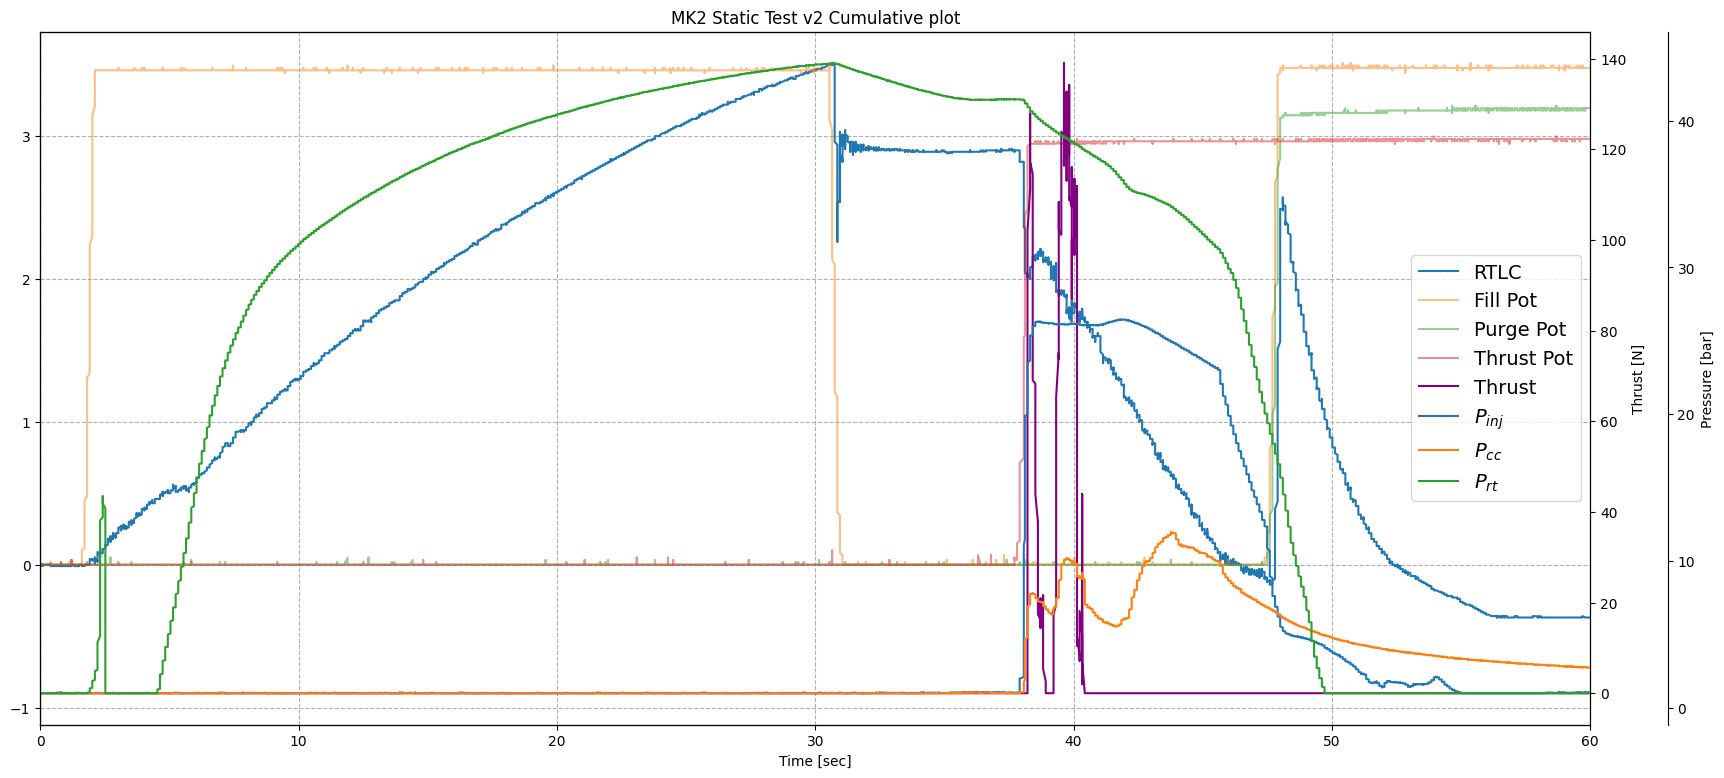

In [5]:
fig,ax = plt.subplots(figsize = (20,9))
# axins = ax.inset_axes([0.1,0.5,0.4,0.4])
ax.set_title("MK2 Static Test v2 Cumulative plot")
ax.set_xlabel("Time [sec]")
handles = []
ax1 = ax.twinx()
ax2 = ax.twinx()
ax2.spines.right.set_position(("axes", 1.05))

l1, = ax.plot(times['lr'],data['lr'], label = "RTLC")
# axins.plot(times['lr'],data['lr'])
handles.append(l1)

pot_scaling_factor = max(data['wf']) / max(data['lr'])
data['wf'] = [i/pot_scaling_factor for i in data['wf']]
data['wp'] = [i/pot_scaling_factor for i in data['wp']]
data['wt'] = [i/pot_scaling_factor for i in data['wt']]

l2, = ax.plot(times['wf'],data['wf'], label = "Fill Pot", alpha = 0.5)
# axins.plot(times['wf'],data['wf'],alpha = 0.5)
handles.append(l2)

l3, = ax.plot(times['wp'],data['wp'], label = "Purge Pot", alpha = 0.5)
# axins.plot(times['wp'],data['wp'],alpha = 0.5)
handles.append(l3)

l4, = ax.plot(times['wt'],data['wt'], label = "Thrust Pot", alpha = 0.5)
# axins.plot(times['wt'],data['wt'],alpha = 0.5)
handles.append(l4)

l5, = ax1.plot(times['lc1'],data['lc1'],label = "Thrust", c= "purple")
handles.append(l5)

l6, = ax2.plot(times['pi'],data['pi'], label = "$P_{inj}$")
handles.append(l6)

l7, = ax2.plot(times['pc'],data['pc'], label = "$P_{cc}$")
handles.append(l7)

l8, = ax2.plot(times['pr'],data['pr'], label = "$P_{rt}$")
handles.append(l8)

# ax.set_ylim(0,7)
ax.set_xlim(0,60)
# axins.set_ylim(4.5,6)
# axins.set_xlim(test_start_time,600) # for seconds
# # axins.set_xlim(550*1000,650*1000) # for milliseconds
# ax.indicate_inset_zoom(axins)
ax.legend(handles = handles,prop={'size': 14})
ax.grid(linestyle = '--')
# axins.grid(linestyle = '--')


ax1.set_ylabel("Thrust [N]")

ax2.set_ylabel("Pressure [bar]")

plt.rcParams['figure.dpi'] = 800
# plt.savefig("time_rtlc.png",dpi = 800)
plt.show()